# Consensus Clustering
Rebuild the model from [Paper](http://link.springer.com/article/10.1023%2FA%3A1023949509487).  
The [Data](https://clusteval.sdu.dk/313/datasets/download/264461) (38 patients, 99 features) is about gene expression.

### Load Data 

In [1]:
# load data
import pickle
import numpy as np

DATA_PATH = "data"

def load():
    with open(DATA_PATH,'rb') as f:
        return pickle.load(f)

def dump(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocal=pickle.HIGHEST_PROTOCOL)

data, names = load()
N, P = data.shape
labels_true = [0]*20+[1]*8+[2]*10
data.shape

(38, 999)

### 3D Plot and Measurement

In [2]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(labels = np.zeros(38,int),size=10):
    # get 3PC from PCA
    dimen = 3
    data_t = PCA(n_components=dimen).fit_transform(data)
    # mark and color
    colors = "grcmyb"*11
    markers = 'oh,^v*+xd|_'*6
    # plot each cluster
    fig = plt.figure(figsize=(size,size*0.8))
    ax = fig.add_subplot(111, projection='3d')
    legends=[]
    leg_desc=[]
    for lab in [-1]+range(max(labels)+1):
        if lab==-1:
            if not -1 in labels: continue
            legends.append(ax.scatter(*[data_t[np.argwhere(labels==lab),i] for i in xrange(dimen)],c='k',
                   marker='.',s=30))
            leg_desc.append('noises      : %d' % sum(labels==lab))
        else:
            legends.append(ax.scatter(*[data_t[np.argwhere(labels==lab),i] for i in xrange(dimen)],c=colors[lab],
                   marker=markers[lab],s=120))
            leg_desc.append("cluster #%d: %d" % (lab+1, sum(labels==lab)))
    plt.legend(legends,leg_desc,fontsize=size*1.2,loc=4)
    plt.title("first 3 principle components --3D plot",size=size*1.6)
    plt.show()

# measurement
import pprint
from sklearn import metrics  
from collections import defaultdict

def scores(data,labels):
    print('Estimated number of clusters: %d' % (max(labels)+1))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
    print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
    if max(labels)>0:
        print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data, labels, metric='sqeuclidean'))
        
def check_names(labels,names=names):
    clusters = defaultdict(list)
    for i in xrange(len(labels)):
        clusters[labels[i]].append(names[i])
    return clusters

def show(data,labels):
    plot3d(labels)
    scores(data,labels)
    print '-'*20
    pprint.pprint(dict(check_names(labels)))

### Predefined Functions and Classes
1. Define two ***resample*** methods  
2. Define two ***clustering*** methods  
3. Define the consensus clustering class  

In [3]:
import numpy as np
from collections import defaultdict
    
# define subsample
def subsample(data,rsize):
    assert rsize<=1 and rsize>=0
    return np.random.choice(range(len(data)),size=int(len(data)*rsize),replace=False)

# define bootstrap
def bootstrap(data,rsize=None):
    #rsize no use, just coodinate with subsample's args list
    from sklearn.utils import resample
    return np.random.choice(range(len(data)),size=len(data),replace=True)

# define Hierarchical Agglometrative Clustering 
def HC(data,K):
    from sklearn.cluster import AgglomerativeClustering as Aggl
    model = Aggl(n_clusters=K)
    model.fit(data)
    return model.labels_

# define KMeans
def KM(data,K):
    from sklearn.cluster import KMeans 
    model = KMeans(n_clusters=K)
    model.fit(data)
    return model.labels_

# consensus clustering class
class ConsClust(object):
    # CMethod:       Clustering function. The clustering algorithm must support
    #                pre-setting number of clustering, like kMeans and HC.
    #                Require two parameters:
    #                .. data: the data to be clustered
    #                .. K   : the number of clusters to be pre-set.
    # ResampleScheme Resample function. The way consensus clustering resample from
    #                from original data. Could be subsample or bootstrap. Resample
    #                funtion must return the resample indeice instead data
    def __init__(self, CMethod, ResampleScheme, H=500, K=None, resample_size=.8):
        self.CMethod=CMethod
        self.resample=ResampleScheme
        self.H=H
        self.K=K
        self.rsize=resample_size
        self.Mats={}
        self.CDF={}
        self.A={}
        self.reorder_list={}
        self.indexes = {}
        self.BestK=None
    
    def fit(self, data):
        if self.K: KMax=self.K
        else: KMax=(len(data)+2)/3
        #MI, Matrix for counting resampled times
        #MC, Matrix for calc consensus scores
        for K in xrange(2,KMax+1):
            MI = np.matrix(np.zeros([len(data)]*2))
            MC = np.matrix(np.zeros([len(data)]*2))
            for times in xrange(self.H):
                #resample
                dHi=self.resample(data,rsize=self.rsize)
                #record sampled points
                self._CRP(dHi,len(data),MI)
                #clustering
                dHci=self.CMethod(data[dHi],K)
                #record same cluster pairs
                self._CSCP(self._trsIdx(dHi,dHci,len(data)),MC)
                #return dHi,dHci,MI,MC #########
            self.Mats[K] = MC/MI
            self.CDF[K],self.A[K] = self._CDF(self.Mats[K])
            self.reorder_list[K], self.indexes[K] = self._reorder(self.Mats,K)
        ### best
    
    def _CDF(self,mat,gap=.01):
        res=[0]
        g=gap
        freq=0
        cuml=0
        last=None
        for i in sorted(list(np.array(mat.flatten())[0])):
            if i>g:
                g+=gap
                res.append(freq)
                if last:
                    cuml+=freq*(i-last)
                freq+=1     
            else:
                freq+=1
            last=i
        else:
            res.append(freq)
        return np.array(res,float)/res[-1],cuml/res[-1]    
    
    def _CRP(self,sampled,L,mat):
        #counting resampled pairs
        for j in xrange(L):
            for i in xrange(L):
                if i in sampled and j in sampled:
                    mat[i,j]+=1
        return mat 
    
    def _CSCP(self,index,mat):
        #counting the same cluster pairs
        tmp =defaultdict(lambda:[])
        for i in xrange(len(index)):
            tmp[index[i]].append(i)
        for v in tmp:
            if v>=0:
                for j in xrange(len(tmp[v])):
                    for i in xrange(len(tmp[v])):
                        mat[tmp[v][i],tmp[v][j]]+=1
        return mat
    
    def _trsIdx(self,sampled,cidx,L):
        # transform the lables on sampled data to original data
        res=-np.ones(L)
        for i in xrange(len(cidx)):
            res[sampled[i]]=cidx[i]
        return res
    
    def _reorder(self,mats,K):
        mat=mats[K]
        grpIDs=set([])
        theta=step=0.5
        while len(grpIDs)!=K:
            grp = np.arange(len(mat))
            for i in xrange(len(mat)):
                for j in xrange(i+1,len(mat)):
                    if mat[i,j]>theta:
                        grp[j]=grp[i]
            grpIDs = set(grp)
            step/=2
            if len(grpIDs)>K:
                theta-=step
            if len(grpIDs)<K:
                theta+=step  
        res=[]
        for g in sorted(list(grpIDs)):
            res.append(np.arange(len(mat))[grp==g])
        reordered = (np.concatenate(res))
        idx_dict={}
        for i in xrange(len(res)):
            for j in res[i]:
                idx_dict[j]=i
        cidx = [idx_dict[i] for i in sorted(idx_dict.keys())]
        return reordered, np.array(cidx)

### Consensus Matrix Plot

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

def ccplot(cc,K,sub=False):
    reorder=cc.reorder_list[K]
    plt.matshow(1-cc.Mats[K][reorder][:,reorder],cmap=plt.cm.gray)
    if not sub:plt.show()

ConsClust.ccplot = ccplot   

## Experiment
***HC, subsample***

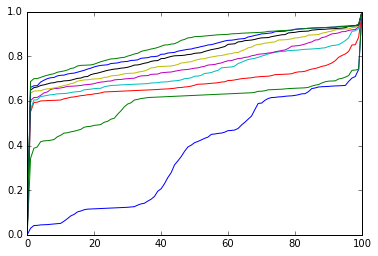

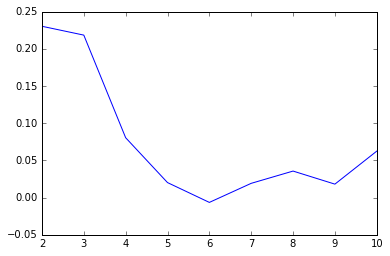

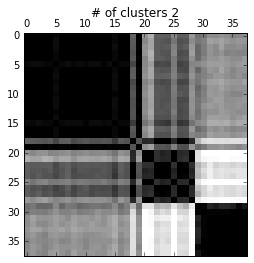

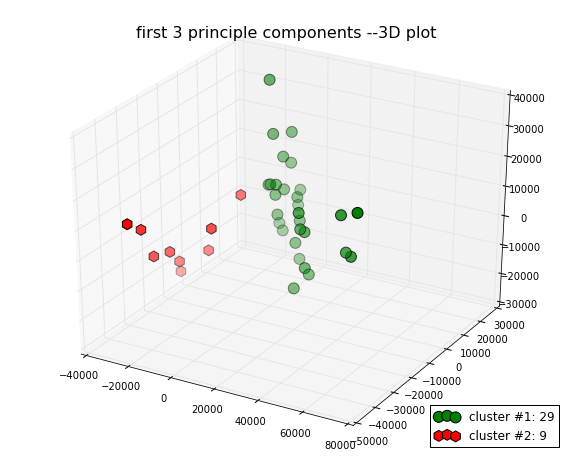

Estimated number of clusters: 2
Homogeneity: 0.292
Completeness: 0.543
V-measure: 0.380
Adjusted Rand Index: 0.292
Adjusted Mutual Information: 0.270
Silhouette Coefficient: 0.367
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'ALL_22474_T.cell_2',
     'AML_13',
     'AML_13_2',
     'AML_16',
     'AML_16_2',
     'AML_1',
     'AML_1_2',
     'AML_3',
     'AML_3_2',
     'AML_6',
     'AML_6_2'],
 1: ['ALL_20414_B.cell_2',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'A

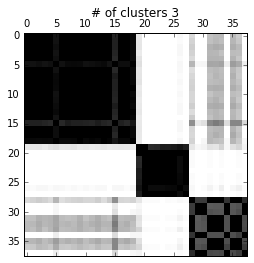

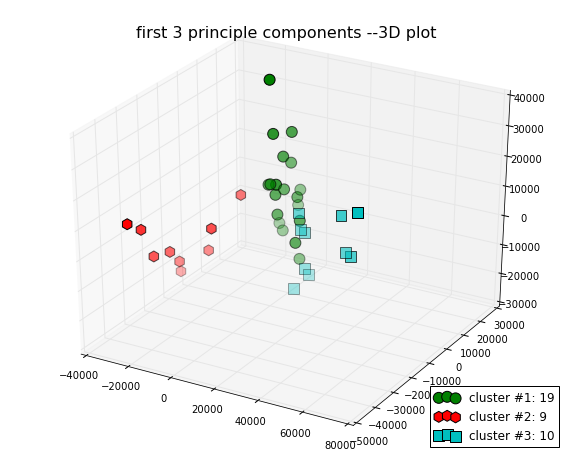

Estimated number of clusters: 3
Homogeneity: 0.691
Completeness: 0.677
V-measure: 0.684
Adjusted Rand Index: 0.715
Adjusted Mutual Information: 0.657
Silhouette Coefficient: 0.432
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_20414_B.cell_2',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 2: ['ALL_22474_T.cell_2',
     'AML_13_2',
     'AML_16',
     'AML_16_2',
     'AML_1',
     

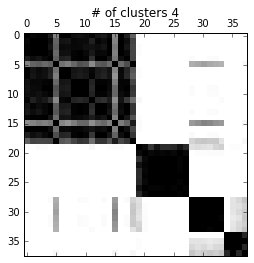

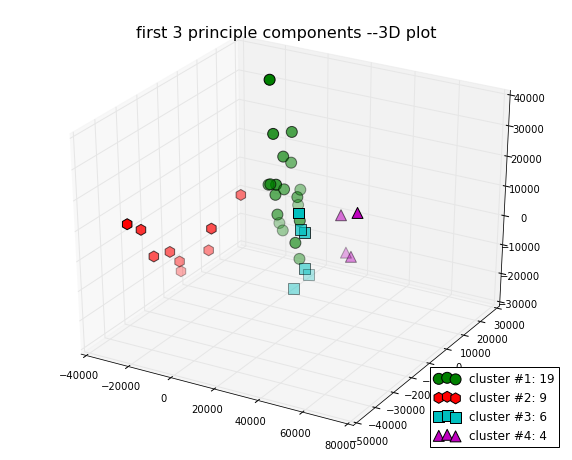

Estimated number of clusters: 4
Homogeneity: 0.705
Completeness: 0.590
V-measure: 0.643
Adjusted Rand Index: 0.660
Adjusted Mutual Information: 0.555
Silhouette Coefficient: 0.373
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_20414_B.cell_2',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 2: ['ALL_22474_T.cell_2', 'AML_16_2', 'AML_1', 'AML_1_2', 'AML_3_2', 'AML_6'],
 3: ['AML_13_2'

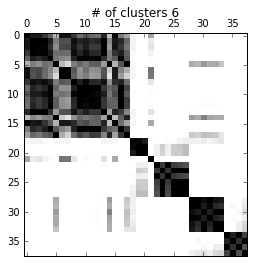

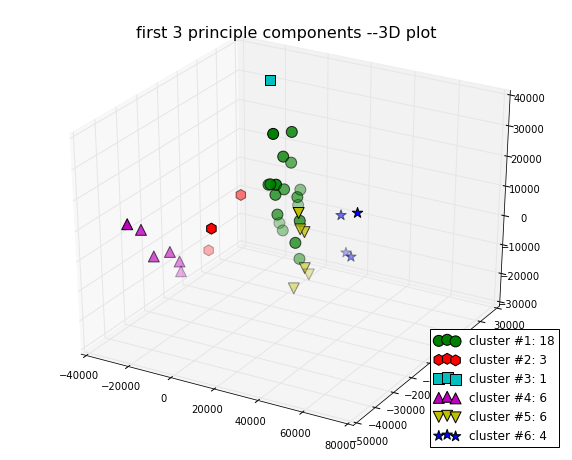

Estimated number of clusters: 6
Homogeneity: 0.781
Completeness: 0.540
V-measure: 0.639
Adjusted Rand Index: 0.618
Adjusted Mutual Information: 0.485
Silhouette Coefficient: 0.346
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_20414_B.cell_2', 'ALL_R23_B.cell_2', 'ALL_14402_T.cell_2'],
 2: ['ALL_20185_B.cell'],
 3: ['ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_22474_T.cell'],
 4: ['ALL_22474_T.cell_2', 'AML_16_2', 'AML_1', 'AML_1_2', 'AML_3_2', 'AML_6'],
 5: ['AML_13_2', 'AML_1

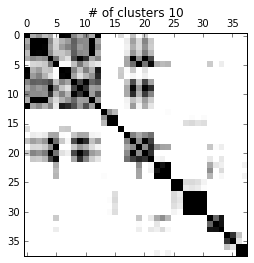

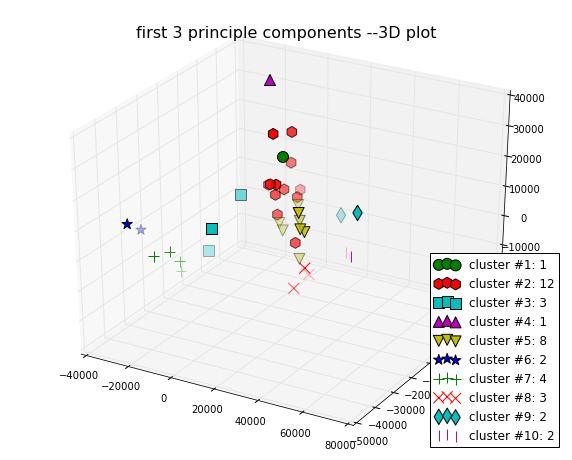

Estimated number of clusters: 10
Homogeneity: 0.758
Completeness: 0.388
V-measure: 0.513
Adjusted Rand Index: 0.332
Adjusted Mutual Information: 0.286
Silhouette Coefficient: 0.136
--------------------
{0: ['ALL_19769_B.cell'],
 1: ['ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell_2'],
 2: ['ALL_20414_B.cell_2', 'ALL_R23_B.cell_2', 'ALL_14402_T.cell_2'],
 3: ['ALL_20185_B.cell'],
 4: ['ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_7092_B.cell',
     'ALL_R23_B.cell',
     'AML_13',
     'AML_1',
     'AML_3_2',
     'AML_6'],
 5: ['ALL_19881_T.cell', 'ALL_9723_T.cell'],
 6: ['ALL_19881_T.cell_2',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_22474_T.cell'],
 7: ['ALL_22474_T.cell_2', 'AML_16_2', 'AML_1_2'],
 8: ['AML

In [5]:
IterTimes=100
MaxK=10

cc = ConsClust(HC,subsample,H=IterTimes,K=MaxK)
cc.fit(data)

fig=plt.figure()
for k in xrange(2,11):
    plt.plot(cc.CDF[k])
    
plt.figure()
plt.plot(cc.A.keys(),[cc.A[i] if i==2 else cc.A[i]-cc.A[i-1] for i in cc.A])
plt.show()

for i in [2,3,4,6,10]:
    cc.ccplot(i,True)
    plt.title("# of clusters %d" % i)
    show(data,cc.indexes[i])

***HC, bootstrap***

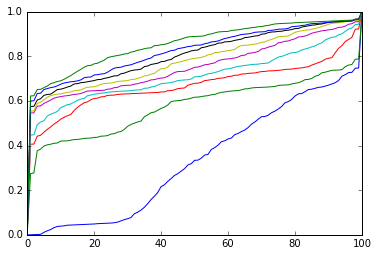

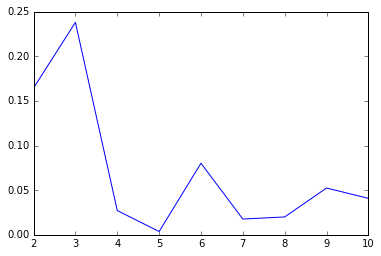

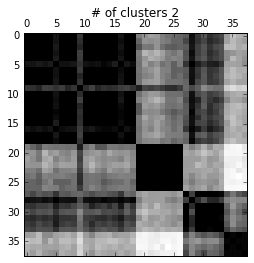

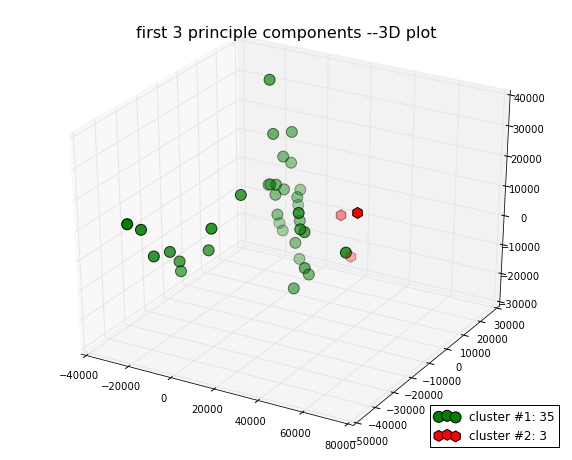

Estimated number of clusters: 2
Homogeneity: 0.113
Completeness: 0.418
V-measure: 0.179
Adjusted Rand Index: 0.088
Adjusted Mutual Information: 0.084
Silhouette Coefficient: 0.492
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_20414_B.cell_2',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell',
     'ALL_22474_T.cell_2',
     'AML_13',
     'AML_16_2',
     'AML_1',
     'AML_1_2',
     'AML_3_2',
     'A

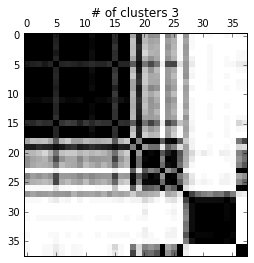

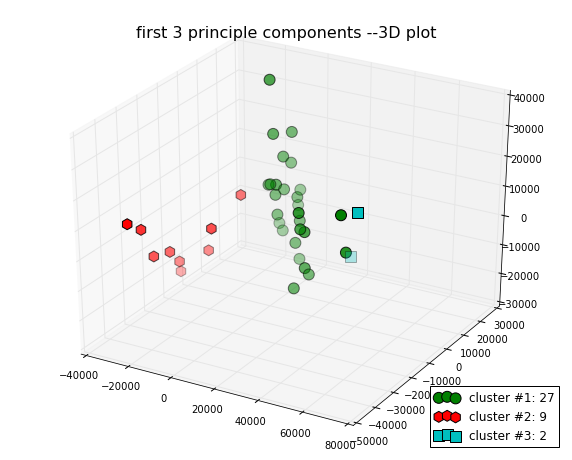

Estimated number of clusters: 3
Homogeneity: 0.351
Completeness: 0.483
V-measure: 0.406
Adjusted Rand Index: 0.326
Adjusted Mutual Information: 0.308
Silhouette Coefficient: 0.379
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'ALL_22474_T.cell_2',
     'AML_13',
     'AML_16_2',
     'AML_1',
     'AML_1_2',
     'AML_3',
     'AML_3_2',
     'AML_6',
     'AML_6_2'],
 1: ['ALL_20414_B.cell_2',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_1440

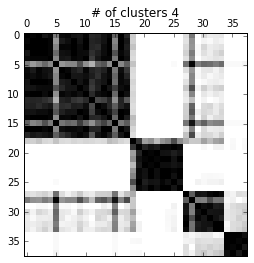

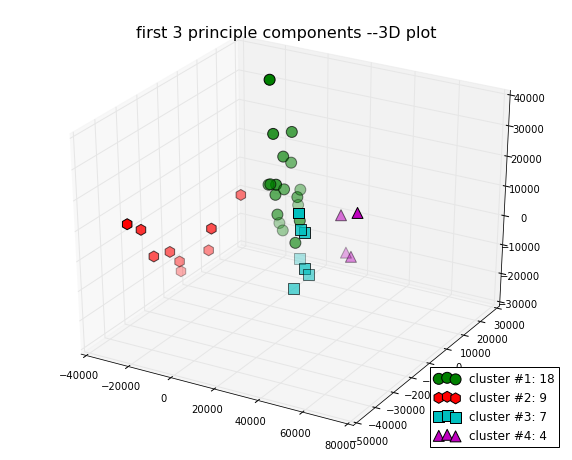

Estimated number of clusters: 4
Homogeneity: 0.802
Completeness: 0.656
V-measure: 0.722
Adjusted Rand Index: 0.726
Adjusted Mutual Information: 0.628
Silhouette Coefficient: 0.368
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell'],
 1: ['ALL_20414_B.cell_2',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 2: ['ALL_22474_T.cell_2',
     'AML_13',
     'AML_16_2',
     'AML_1',
     'AML_1_2',
     'AML_3_2',
     

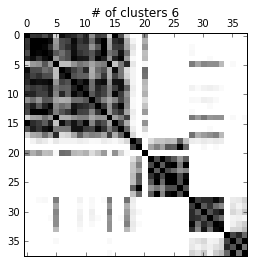

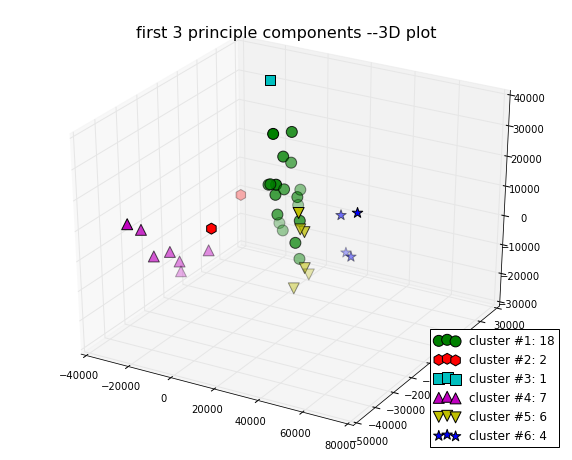

Estimated number of clusters: 6
Homogeneity: 0.830
Completeness: 0.584
V-measure: 0.686
Adjusted Rand Index: 0.645
Adjusted Mutual Information: 0.534
Silhouette Coefficient: 0.325
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_20414_B.cell_2', 'ALL_R23_B.cell_2'],
 2: ['ALL_20185_B.cell'],
 3: ['ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 4: ['ALL_22474_T.cell_2', 'AML_16_2', 'AML_1', 'AML_1_2', 'AML_3_2', 'AML_6'],
 5: ['AML_13_2', '

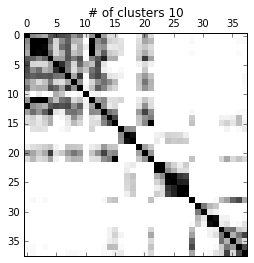

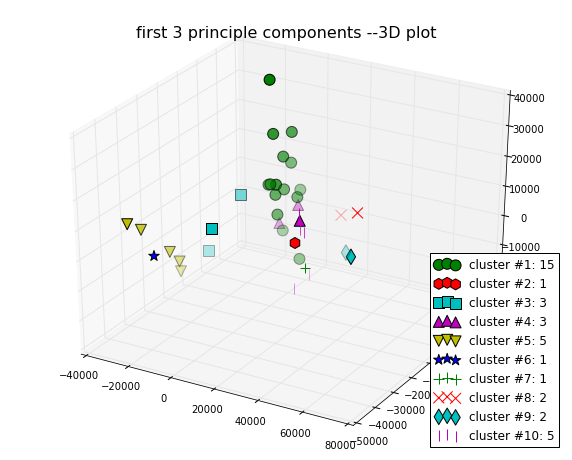

Estimated number of clusters: 10
Homogeneity: 0.856
Completeness: 0.458
V-measure: 0.597
Adjusted Rand Index: 0.454
Adjusted Mutual Information: 0.365
Silhouette Coefficient: 0.056
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_9692_B.cell_2'],
 2: ['ALL_20414_B.cell_2', 'ALL_R23_B.cell_2', 'ALL_14402_T.cell_2'],
 3: ['ALL_20185_B.cell_2', 'ALL_18239_B.cell', 'ALL_7092_B.cell'],
 4: ['ALL_19881_T.cell',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_22474_T.cell'],
 5: ['ALL_19881_T.cell_2'],
 6: ['ALL_22474_T.cell_2'],
 7: ['AML_13_2', 'AML_3'],
 8: ['AML_16', 'AML_6_2'],
 9: ['AML_16_2', 'AML_1', 'A

In [6]:
cc= ConsClust(HC,bootstrap,H=IterTimes,K=MaxK)
cc.fit(data)
fig=plt.figure()
cc.fit(data)
fig=plt.figure()
for k in xrange(2,11):
    plt.plot(cc.CDF[k])
plt.figure()
plt.plot(cc.A.keys(),[cc.A[i] if i==2 else cc.A[i]-cc.A[i-1] for i in cc.A])
plt.show()

for i in [2,3,4,6,10]:
    cc.ccplot(i,True)
    plt.title("# of clusters %d" % i)
    show(data,cc.indexes[i])

***KMeans, subsample***

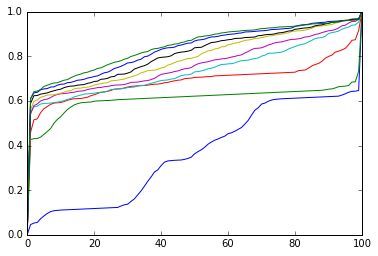

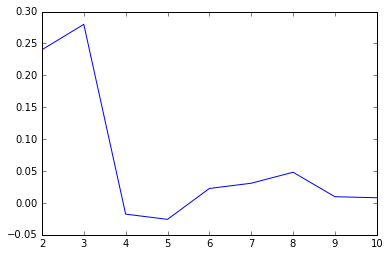

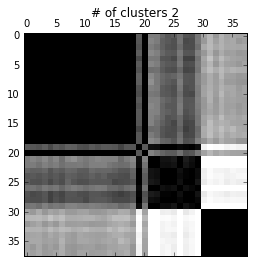

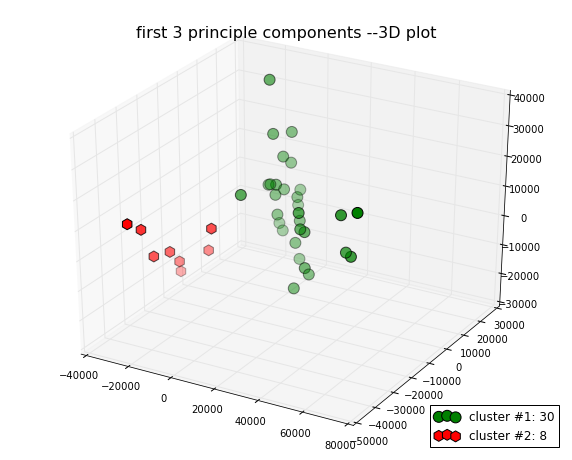

Estimated number of clusters: 2
Homogeneity: 0.325
Completeness: 0.643
V-measure: 0.432
Adjusted Rand Index: 0.336
Adjusted Mutual Information: 0.304
Silhouette Coefficient: 0.384
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_20414_B.cell_2',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'ALL_22474_T.cell_2',
     'AML_13',
     'AML_13_2',
     'AML_16',
     'AML_16_2',
     'AML_1',
     'AML_1_2',
     'AML_3',
     'AML_3_2',
     'AML_6',
     'AML_6_2'],
 1: ['ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'A

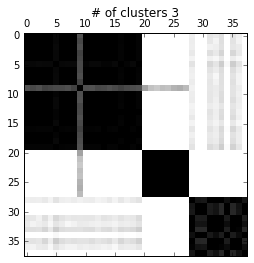

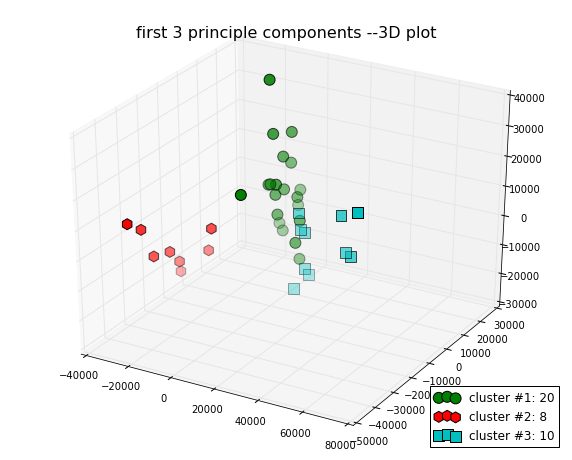

Estimated number of clusters: 3
Homogeneity: 0.735
Completeness: 0.735
V-measure: 0.735
Adjusted Rand Index: 0.787
Adjusted Mutual Information: 0.718
Silhouette Coefficient: 0.439
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_20414_B.cell_2',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 2: ['ALL_22474_T.cell_2',
     'AML_13_2',
     'AML_16',
     'AML_16_2',
     'AML_1',
     

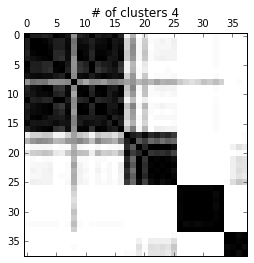

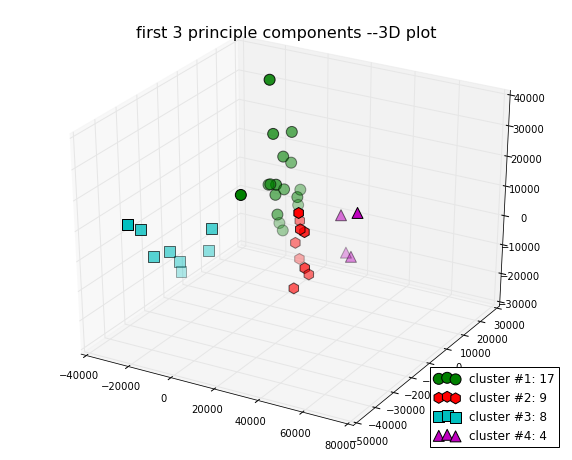

Estimated number of clusters: 4
Homogeneity: 0.724
Completeness: 0.582
V-measure: 0.645
Adjusted Rand Index: 0.647
Adjusted Mutual Information: 0.548
Silhouette Coefficient: 0.358
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_20414_B.cell_2',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell'],
 1: ['ALL_9692_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_22474_T.cell_2',
     'AML_13',
     'AML_16_2',
     'AML_1',
     'AML_1_2',
     'AML_3_2',
     'AML_6'],
 2: ['ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_

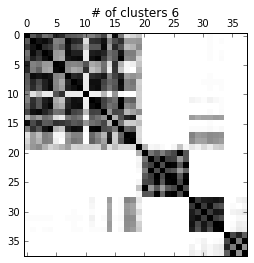

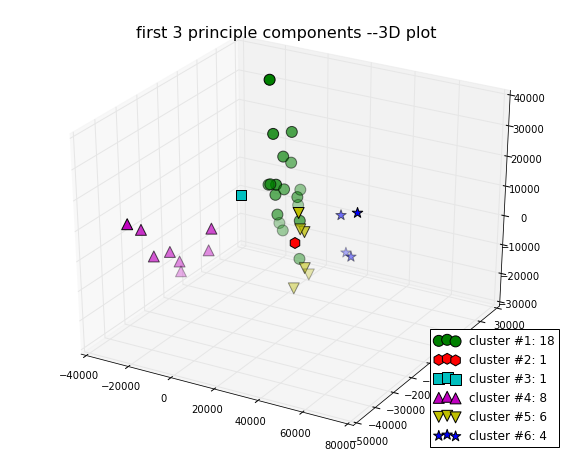

Estimated number of clusters: 6
Homogeneity: 0.752
Completeness: 0.546
V-measure: 0.633
Adjusted Rand Index: 0.621
Adjusted Mutual Information: 0.491
Silhouette Coefficient: 0.083
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_9692_B.cell_2'],
 2: ['ALL_20414_B.cell_2'],
 3: ['ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 4: ['ALL_22474_T.cell_2', 'AML_16_2', 'AML_1', 'AML_1_2', 'AML_3_2', 'AML_6'],
 5: ['AML_13_

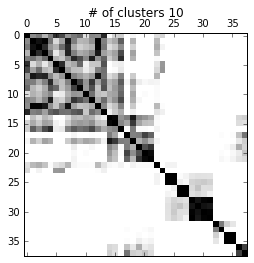

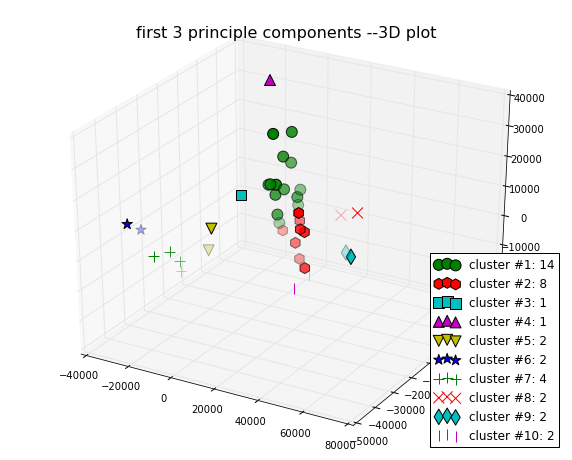

Estimated number of clusters: 10
Homogeneity: 0.762
Completeness: 0.408
V-measure: 0.532
Adjusted Rand Index: 0.415
Adjusted Mutual Information: 0.306
Silhouette Coefficient: 0.312
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell_2'],
 1: ['ALL_9692_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_R23_B.cell',
     'ALL_22474_T.cell_2',
     'AML_13',
     'AML_1',
     'AML_3_2',
     'AML_6'],
 2: ['ALL_20414_B.cell_2'],
 3: ['ALL_20185_B.cell'],
 4: ['ALL_R23_B.cell_2', 'ALL_14402_T.cell_2'],
 5: ['ALL_19881_T.cell', 'ALL_9723_T.cell'],
 6: ['ALL_19881_T.cell_2',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_22474_T.cell'],
 7: ['AML_13_2', 'AML_3'],
 

In [7]:
cc = ConsClust(KM,subsample,IterTimes,K=MaxK)
cc.fit(data)
fig=plt.figure()
for k in xrange(2,11):
    plt.plot(cc.CDF[k])
plt.figure()
plt.plot(cc.A.keys(),[cc.A[i] if i==2 else cc.A[i]-cc.A[i-1] for i in cc.A])
plt.show()

for i in [2,3,4,6,10]:
    cc.ccplot(i,True)
    plt.title("# of clusters %d" % i)
    show(data,cc.indexes[i])

***KMeans, bootstrap***

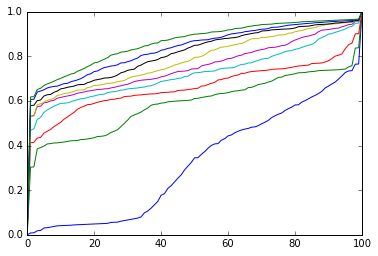

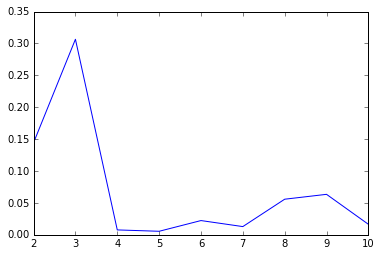

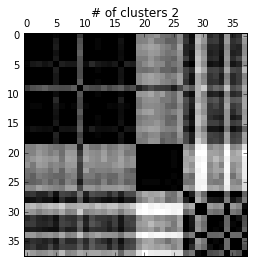

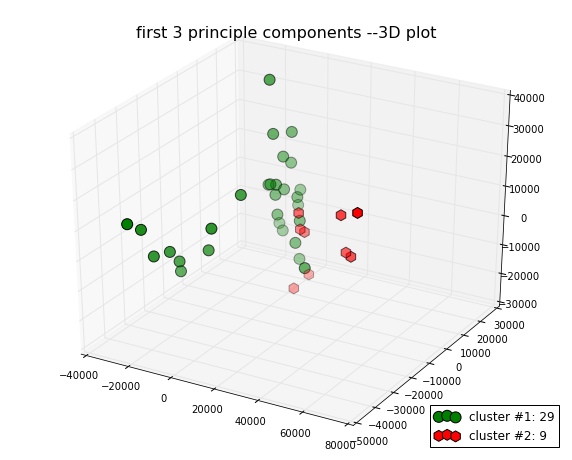

Estimated number of clusters: 2
Homogeneity: 0.454
Completeness: 0.844
V-measure: 0.590
Adjusted Rand Index: 0.474
Adjusted Mutual Information: 0.437
Silhouette Coefficient: 0.363
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_20414_B.cell_2',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell',
     'ALL_22474_T.cell_2',
     'AML_13'],
 1: ['AML_13_2',
     'AML_16',
     'AML_16_2',
     'AML_1',
     '

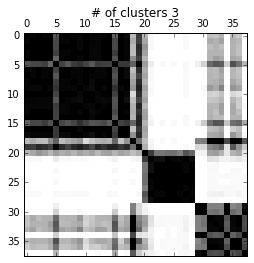

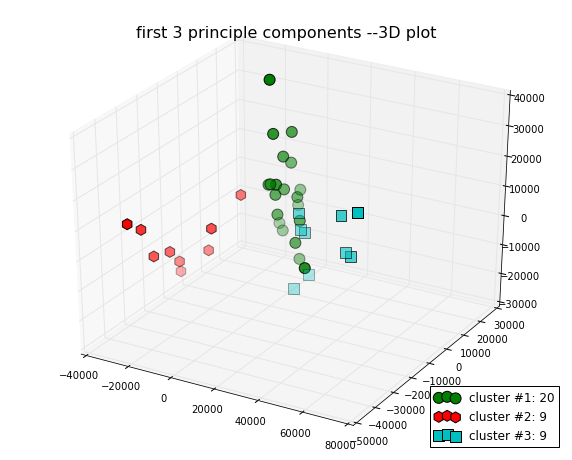

Estimated number of clusters: 3
Homogeneity: 0.673
Completeness: 0.671
V-measure: 0.672
Adjusted Rand Index: 0.687
Adjusted Mutual Information: 0.650
Silhouette Coefficient: 0.414
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'ALL_22474_T.cell_2',
     'AML_13'],
 1: ['ALL_20414_B.cell_2',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 2: ['AML_13_2',
     'AML_16',
     'AML_16_2',
     'AML_1',
     

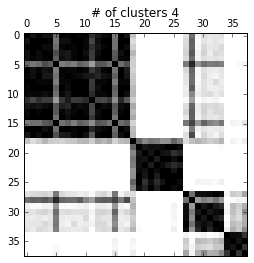

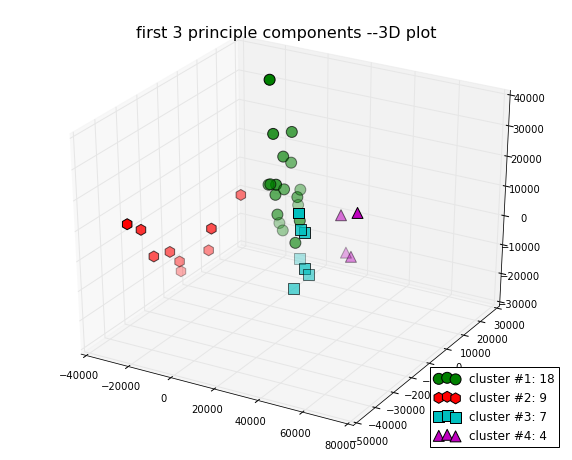

Estimated number of clusters: 4
Homogeneity: 0.802
Completeness: 0.656
V-measure: 0.722
Adjusted Rand Index: 0.726
Adjusted Mutual Information: 0.628
Silhouette Coefficient: 0.368
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell'],
 1: ['ALL_20414_B.cell_2',
     'ALL_R23_B.cell_2',
     'ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 2: ['ALL_22474_T.cell_2',
     'AML_13',
     'AML_16_2',
     'AML_1',
     'AML_1_2',
     'AML_3_2',
     

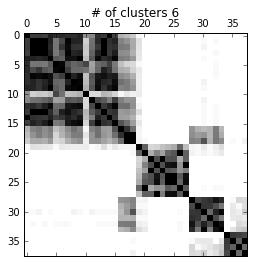

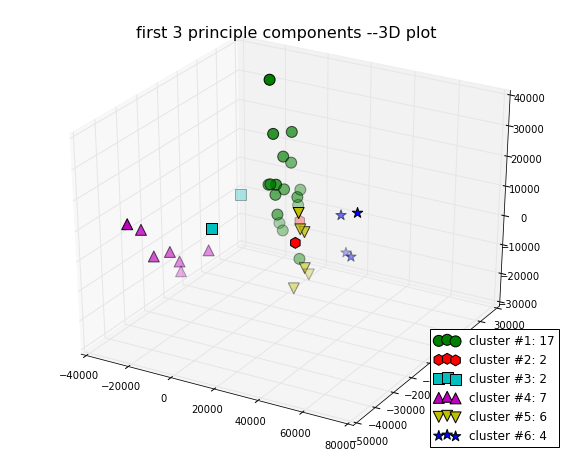

Estimated number of clusters: 6
Homogeneity: 0.832
Completeness: 0.560
V-measure: 0.670
Adjusted Rand Index: 0.595
Adjusted Mutual Information: 0.508
Silhouette Coefficient: 0.072
--------------------
{0: ['ALL_19769_B.cell',
     'ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell_2',
     'ALL_R23_B.cell',
     'AML_13'],
 1: ['ALL_9692_B.cell_2', 'ALL_7092_B.cell'],
 2: ['ALL_20414_B.cell_2', 'ALL_R23_B.cell_2'],
 3: ['ALL_19881_T.cell',
     'ALL_19881_T.cell_2',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_14402_T.cell_2',
     'ALL_22474_T.cell'],
 4: ['ALL_22474_T.cell_2', 'AML_16_2', 'AML_1', 'AML_1_2', 'AML_3_2', 'AML_6'],
 5: ['AML_13_2', 'AML_1

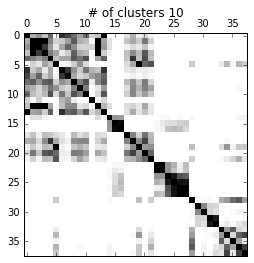

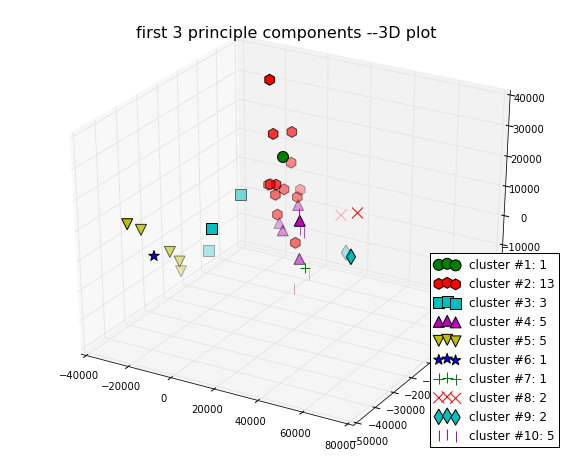

Estimated number of clusters: 10
Homogeneity: 0.886
Completeness: 0.459
V-measure: 0.604
Adjusted Rand Index: 0.444
Adjusted Mutual Information: 0.369
Silhouette Coefficient: 0.052
--------------------
{0: ['ALL_19769_B.cell'],
 1: ['ALL_19769_B.cell_2',
     'ALL_28373_B.cell',
     'ALL_28373_B.cell_2',
     'ALL_9692_B.cell',
     'ALL_9692_B.cell_2',
     'ALL_17281_B.cell',
     'ALL_17281_B.cell_2',
     'ALL_20414_B.cell',
     'ALL_549_B.cell',
     'ALL_549_B.cell_2',
     'ALL_20185_B.cell',
     'ALL_18239_B.cell_2',
     'ALL_7092_B.cell_2'],
 2: ['ALL_20414_B.cell_2', 'ALL_R23_B.cell_2', 'ALL_14402_T.cell_2'],
 3: ['ALL_20185_B.cell_2',
     'ALL_18239_B.cell',
     'ALL_7092_B.cell',
     'ALL_R23_B.cell',
     'AML_13'],
 4: ['ALL_19881_T.cell',
     'ALL_9723_T.cell',
     'ALL_9723_T.cell_2',
     'ALL_14402_T.cell',
     'ALL_22474_T.cell'],
 5: ['ALL_19881_T.cell_2'],
 6: ['ALL_22474_T.cell_2'],
 7: ['AML_13_2', 'AML_3'],
 8: ['AML_16', 'AML_6_2'],
 9: ['AML_16_2', '

In [8]:
cc = ConsClust(HC,bootstrap,H=IterTimes,K=MaxK)
cc.fit(data)
fig=plt.figure()
for k in xrange(2,11):
    plt.plot(cc.CDF[k])
plt.figure()
plt.plot(cc.A.keys(),[cc.A[i] if i==2 else cc.A[i]-cc.A[i-1] for i in cc.A])
plt.show()

for i in [2,3,4,6,10]:
    cc.ccplot(i,True)
    plt.title("# of clusters %d" % i)
    show(data,cc.indexes[i])